In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import seaborn as sns
import napari
from skimage.io import imread
from scipy import stats
from copy import deepcopy

In [2]:
os.getcwd()

'/nas/groups/iber/Users/Federico_Carrara/Statistics_Collection/EpiStats'

In [130]:
# Load the data
#separately load the datasets of the different samples

# # BLADDER SAMPLES
# path_to_data = ""
# # path_to_data = r"N:\Users\Federico_Carrara\Cell_Meshes\for_cell_statistics\bladder_samples"

# bladder_MBC19_bottom_df = pd.read_csv(
#     'output_MBC19_S5_St1_Crop_GFP_clean_bottom_s_10_e_6_d_8/cell_stats/stats_dataset_bladder.csv',
#     index_col=False
# )

# bladder_MBC19_top_df = pd.read_csv(
#     'output_MBC19_S5_St1_Crop_GFP_clean_top_s_10_e_6_d_8/cell_stats/stats_dataset_bladder.csv',
#     index_col=False
# )

# bladder_MBC20_bottom_df = pd.read_csv(
#     'output_MBC20_S1e_0a_St2_GFP_clean_bottom_s_10_e_6_d_8/cell_stats/stats_dataset_bladder.csv',
#     index_col=False
# )

# bladder_MBC20_top_df = pd.read_csv(
#     'output_MBC20_S1e_0a_St2_GFP_clean_top_s_10_e_6_d_8/cell_stats/stats_dataset_bladder.csv',
#     index_col=False
# )

bladder_df = pd.read_csv(
    './output_bladder_control_curated_segmentation_s_10_e_6_d_8/cell_stats/bladder_control_curated_segmentation.csv',
    index_col=0
)


# LUNG SAMPLE
# path_to_data = "/nas/groups/iber/Users/Federico_Carrara/Cell_Meshes/for_cell_statistics/lung_samples_s_10_e_2_d_4/"
# path_to_data = r"N:\Users\Federico_Carrara\Cell_Meshes\for_cell_statistics\lung_samples_s_10_e_2_d_4"

lung_df = pd.read_csv(
    './output_lung_new_sample_b_curated_segmentation_central_crop_relabel_seq_s_10_e_6_d_8/cell_stats/stats_dataset_lung_bronchiole.csv',
    index_col=0
)


# INTESTINE SAMPLE
# path_to_data = "/nas/groups/iber/Users/Federico_Carrara/Cell_Meshes/for_cell_statistics/intestine_samples_s_10_e_2_d_4/"
# path_to_data = r"N:\Users\Federico_Carrara\Cell_Meshes\for_cell_statistics\intestine_samples_s_10_e_2_d_4"

intestine_df = pd.read_csv(
    './output_intestine_sample2_b_curated_segmentation_relabel_seq_s_10_e_6_d_8/cell_stats/stats_dataset_intestine_villus.csv',
    index_col=0
)

In [131]:
# # Merge the datasets adding a marker indicating the sample
# #create a list indicating for each cell which sample it belongs to
# which_sample = (["bladder_MBC19"] * bladder_MBC19_bottom_df.shape[0] 
#     + ["bladder_MBC19"] * bladder_MBC19_top_df.shape[0]
#     + ["bladder_MBC20"] * bladder_MBC20_bottom_df.shape[0] 
#     + ["bladder_MBC20"] * bladder_MBC20_top_df.shape[0]
#     + ["lung"] * lung_df.shape[0]
#     + ["intestine"] * intestine_df.shape[0]
# )
# #create a list indicating for each cell which tissue it belongs to
# which_tissue = [np.where("bladder" in name, "bladder", name)[()] for name in which_sample]

#concatenate the dataframe and add the columns
cell_stats_df = pd.concat(
    list([
        # bladder_MBC19_bottom_df, 
        # bladder_MBC19_top_df, 
        # bladder_MBC20_bottom_df,
        # bladder_MBC20_top_df,
        bladder_df,
        lung_df,
        intestine_df
    ]),
    axis=0,
    ignore_index=True
)
# cell_stats_df["tissue_id"] = which_tissue
# cell_stats_df["sample_id"] = which_sample
cell_stats_df

,cell_ID,tissue,file_name,mesh_dir,exclude_cell,area,volume,neighbors,contact_area,num_neighbors,elongation,principal_axes,isoperimetric_ratio,contact_area_fraction,contact_area_distribution,mean_contact_area,total_contact_area
0,1,bladder,../../curated_labels/bladder_control_curated_s...,./output_bladder_control_curated_segmentation_...,False,1.076577,0.077321,[536 558],"(0.0, array([0., 0.]))",2,1.296384,[6.30024209e-10 5.40020729e-10 1.00000000e+00],208.707497,NaN,NaN,NaN,NaN
1,2,bladder,../../curated_labels/bladder_control_curated_s...,./output_bladder_control_curated_segmentation_...,True,NaN,NaN,[],"(None, [])",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,bladder,../../curated_labels/bladder_control_curated_s...,./output_bladder_control_curated_segmentation_...,True,NaN,NaN,[],"(None, [])",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,bladder,../../curated_labels/bladder_control_curated_s...,./output_bladder_control_curated_segmentation_...,True,NaN,NaN,[],"(None, [])",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,bladder,../../curated_labels/bladder_control_curated_s...,./output_bladder_control_curated_segmentation_...,False,1159.586833,2530.995319,[ 3 32 34 47 61 70 73 80 82 106 132 5...,"(None, [])",16,1.532248,[-0.61445824 -0.74901947 -0.24781225],243.403681,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,318,intestine_villus,output_intestine_sample2_b_curated_segmentatio...,output_intestine_sample2_b_curated_segmentatio...,False,1817.346952,4711.895382,[186 211 214 243 269 270 271],NaN,7,2.159739,[ 0.1340902 -0.73973384 -0.65940402],270.347441,0.009187,[2.78182869 2.23860368 2.10359074 1.36736374 2...,2.385097,16.695680
1136,319,intestine_villus,output_intestine_sample2_b_curated_segmentatio...,output_intestine_sample2_b_curated_segmentatio...,False,2205.674936,5530.559740,[ 23 28 53 61 64 259 320],NaN,7,2.384791,[-0.52015751 -0.85406016 -0.00417247],350.821619,0.010521,[2.38307347 4.02564201 5.59829594 2.88502174 5...,3.315281,23.206966
1137,320,intestine_villus,output_intestine_sample2_b_curated_segmentatio...,output_intestine_sample2_b_curated_segmentatio...,False,1323.820985,2820.593120,[ 28 42 60 64 66 83 87 259 317 319 321],NaN,11,1.981633,[ 0.72947482 0.49057528 -0.47665751],291.613012,0.010529,[1.82252737 3.57450798 3.65619779 1.56772792 2...,2.705466,21.643727
1138,321,intestine_villus,output_intestine_sample2_b_curated_segmentatio...,output_intestine_sample2_b_curated_segmentatio...,False,2055.554380,4508.226099,[ 42 60 64 66 83 87 317 320],NaN,8,1.285178,[-0.11478008 -0.42237853 0.89912286],427.341956,0.010586,[1.8832486 1.41157458 4.53402239 3.09459183 2...,2.685836,21.486690


In [133]:
# Rename 'cell_area' column to 'cell_surface_area'
cell_stats_df["surface_area"] = cell_stats_df["area"]
cell_stats_df.drop(columns=["area"], inplace=True)
cell_stats_df

,cell_ID,tissue,file_name,mesh_dir,exclude_cell,volume,neighbors,contact_area,num_neighbors,elongation,principal_axes,isoperimetric_ratio,contact_area_fraction,contact_area_distribution,mean_contact_area,total_contact_area,surface_area
0,1,bladder,../../curated_labels/bladder_control_curated_s...,./output_bladder_control_curated_segmentation_...,False,0.077321,[536 558],"(0.0, array([0., 0.]))",2,1.296384,[6.30024209e-10 5.40020729e-10 1.00000000e+00],208.707497,NaN,NaN,NaN,NaN,1.076577
1,2,bladder,../../curated_labels/bladder_control_curated_s...,./output_bladder_control_curated_segmentation_...,True,NaN,[],"(None, [])",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,bladder,../../curated_labels/bladder_control_curated_s...,./output_bladder_control_curated_segmentation_...,True,NaN,[],"(None, [])",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,bladder,../../curated_labels/bladder_control_curated_s...,./output_bladder_control_curated_segmentation_...,True,NaN,[],"(None, [])",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,bladder,../../curated_labels/bladder_control_curated_s...,./output_bladder_control_curated_segmentation_...,False,2530.995319,[ 3 32 34 47 61 70 73 80 82 106 132 5...,"(None, [])",16,1.532248,[-0.61445824 -0.74901947 -0.24781225],243.403681,NaN,NaN,NaN,NaN,1159.586833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,318,intestine_villus,output_intestine_sample2_b_curated_segmentatio...,output_intestine_sample2_b_curated_segmentatio...,False,4711.895382,[186 211 214 243 269 270 271],NaN,7,2.159739,[ 0.1340902 -0.73973384 -0.65940402],270.347441,0.009187,[2.78182869 2.23860368 2.10359074 1.36736374 2...,2.385097,16.695680,1817.346952
1136,319,intestine_villus,output_intestine_sample2_b_curated_segmentatio...,output_intestine_sample2_b_curated_segmentatio...,False,5530.559740,[ 23 28 53 61 64 259 320],NaN,7,2.384791,[-0.52015751 -0.85406016 -0.00417247],350.821619,0.010521,[2.38307347 4.02564201 5.59829594 2.88502174 5...,3.315281,23.206966,2205.674936
1137,320,intestine_villus,output_intestine_sample2_b_curated_segmentatio...,output_intestine_sample2_b_curated_segmentatio...,False,2820.593120,[ 28 42 60 64 66 83 87 259 317 319 321],NaN,11,1.981633,[ 0.72947482 0.49057528 -0.47665751],291.613012,0.010529,[1.82252737 3.57450798 3.65619779 1.56772792 2...,2.705466,21.643727,1323.820985
1138,321,intestine_villus,output_intestine_sample2_b_curated_segmentatio...,output_intestine_sample2_b_curated_segmentatio...,False,4508.226099,[ 42 60 64 66 83 87 317 320],NaN,8,1.285178,[-0.11478008 -0.42237853 0.89912286],427.341956,0.010586,[1.8832486 1.41157458 4.53402239 3.09459183 2...,2.685836,21.486690,2055.554380


In [138]:
# # Delete cells with 0 neighbors
# cell_stats_df = cell_stats_df.drop(index=cell_stats_df[cell_stats_df.neighbors == 0].index)
# cell_stats_df.shape

In [137]:
# Delete cells whose volume is lower than the 5% quantile
tissues = cell_stats_df['tissue'].unique()
for tissue in tissues:
    tissue_df = cell_stats_df[cell_stats_df['tissue'] == tissue]
    lower_threshold = np.quantile(tissue_df["volume"][~np.isnan(cell_stats_df['volume'])], 0.05)
    cell_stats_df = cell_stats_df.drop(index=cell_stats_df[(cell_stats_df['tissue'] == tissue) * (cell_stats_df["volume"] < lower_threshold)].index)
cell_stats_df.shape

(1100, 17)

In [139]:
# Number of samples and number of samples for each tissue
print(np.unique(cell_stats_df["tissue"], return_counts=True))
print(len(cell_stats_df))

(array(['bladder', 'intestine_villus', 'lung_bronchiole'], dtype=object), array([618, 309, 173]))
1100


In [140]:
#make a new df with only numerical attributes
numerical_cell_stats_df = deepcopy(cell_stats_df)
numerical_cell_stats_df = cell_stats_df.drop(columns=[
    'file_name', 'mesh_dir', 'exclude_cell',
    'neighbors', 'principal_axes', 'contact_area_fraction', 'contact_area',
    'contact_area_distribution', 'mean_contact_area', 'total_contact_area',
])
print(numerical_cell_stats_df.columns, numerical_cell_stats_df.shape)

# remove nans and Nones
numerical_cell_stats_df = numerical_cell_stats_df.dropna()
print(numerical_cell_stats_df.shape)

numeric_features = [
    'volume', 'num_neighbors', 'elongation',
    'isoperimetric_ratio', 'surface_area'
]

#standardize the values
scaler = StandardScaler()
scaled_values = scaler.fit_transform(numerical_cell_stats_df[numeric_features].values)
scaled_cell_stats_df = numerical_cell_stats_df.copy()
scaled_cell_stats_df[numeric_features] = scaled_values
scaled_cell_stats_df

Index(['cell_ID', 'tissue', 'volume', 'num_neighbors', 'elongation',
       'isoperimetric_ratio', 'surface_area'],
      dtype='object') (1100, 7)
(742, 7)


,cell_ID,tissue,volume,num_neighbors,elongation,isoperimetric_ratio,surface_area
4,5,bladder,-0.175293,1.249531,-0.434772,-0.417978,-0.181878
14,15,bladder,-0.478650,0.990405,0.445338,1.131467,-0.409820
33,34,bladder,0.009244,0.472154,-0.436950,-0.356090,0.029223
48,49,bladder,-0.254911,0.731280,0.415507,-0.020867,-0.225332
49,50,bladder,-0.470766,-0.305224,0.564265,0.681034,-0.435698
...,...,...,...,...,...,...,...
1135,318,intestine_villus,0.587318,-1.082601,0.936076,-0.001423,0.668813
1136,319,intestine_villus,0.873587,-1.082601,1.427736,1.242724,1.171043
1137,320,intestine_villus,-0.074028,-0.046098,0.546977,0.327347,0.030529
1138,321,intestine_villus,0.516100,-0.823475,-0.974533,2.425744,0.976890


In [4]:
#  Data exploration: feature correlation
corr = scaled_cell_stats_df[numeric_features].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='viridis',
    square=True,
    cbar_kws={"shrink": .5}
)

features = [col.replace("cell_", "").replace("_", " ").title() for col in scaled_cell_stats_df[numeric_features].columns]

ax.set_xticklabels(
    features,
    rotation=45,
    horizontalalignment='right',
    fontsize=12)

ax.set_title("Correlation Matrix", fontsize=24)
ax.set_yticklabels(features, fontsize=12)

NameError: name 'scaled_cell_stats_df' is not defined

In [3]:
# Compute principal components
#perform PCA
pca = PCA(n_components=2)
pca_out = pca.fit(scaled_cell_stats_df[numeric_features])

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


NameError: name 'scaled_cell_stats_df' is not defined

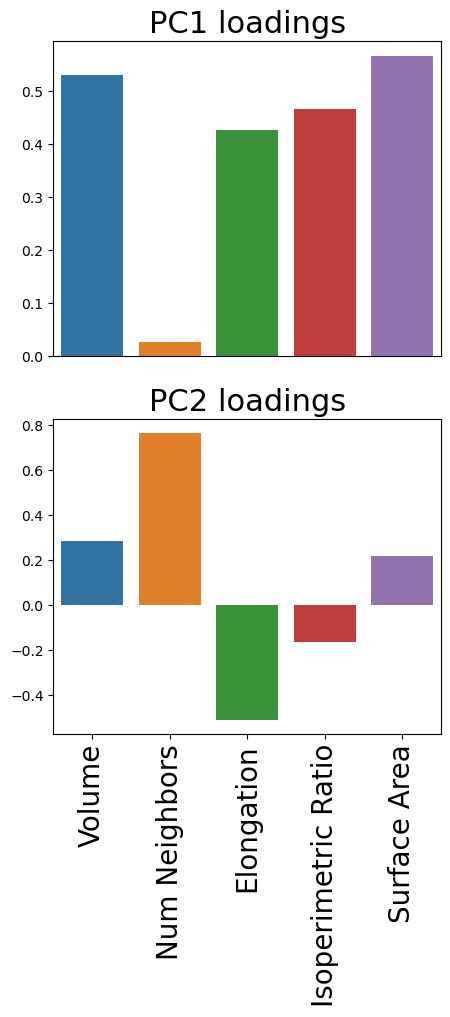

In [26]:
#analyze PCA components to see their composition
plt.rcParams['figure.figsize'] = [5, 9]
fig = plt.Figure()

features = [col.replace("cell_", "").replace("_", " ").title() for col in scaled_cell_stats_df[numeric_features].columns]

ax1 = plt.subplot(211)
sns.barplot(
    x=features,
    y=pca_out.components_[0],
    ax=ax1
)
ax1.set_title("PC1 loadings", fontsize=22)
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

ax2 = plt.subplot(212)
sns.barplot(
    x=features,
    y=pca_out.components_[1],
    ax=ax2
)
ax2.set_title("PC2 loadings", fontsize=22)
ax2.tick_params(axis='x', labelrotation=90, labelsize=20)

In [27]:
pca_out.explained_variance_ratio_

array([0.53860899, 0.26193356])

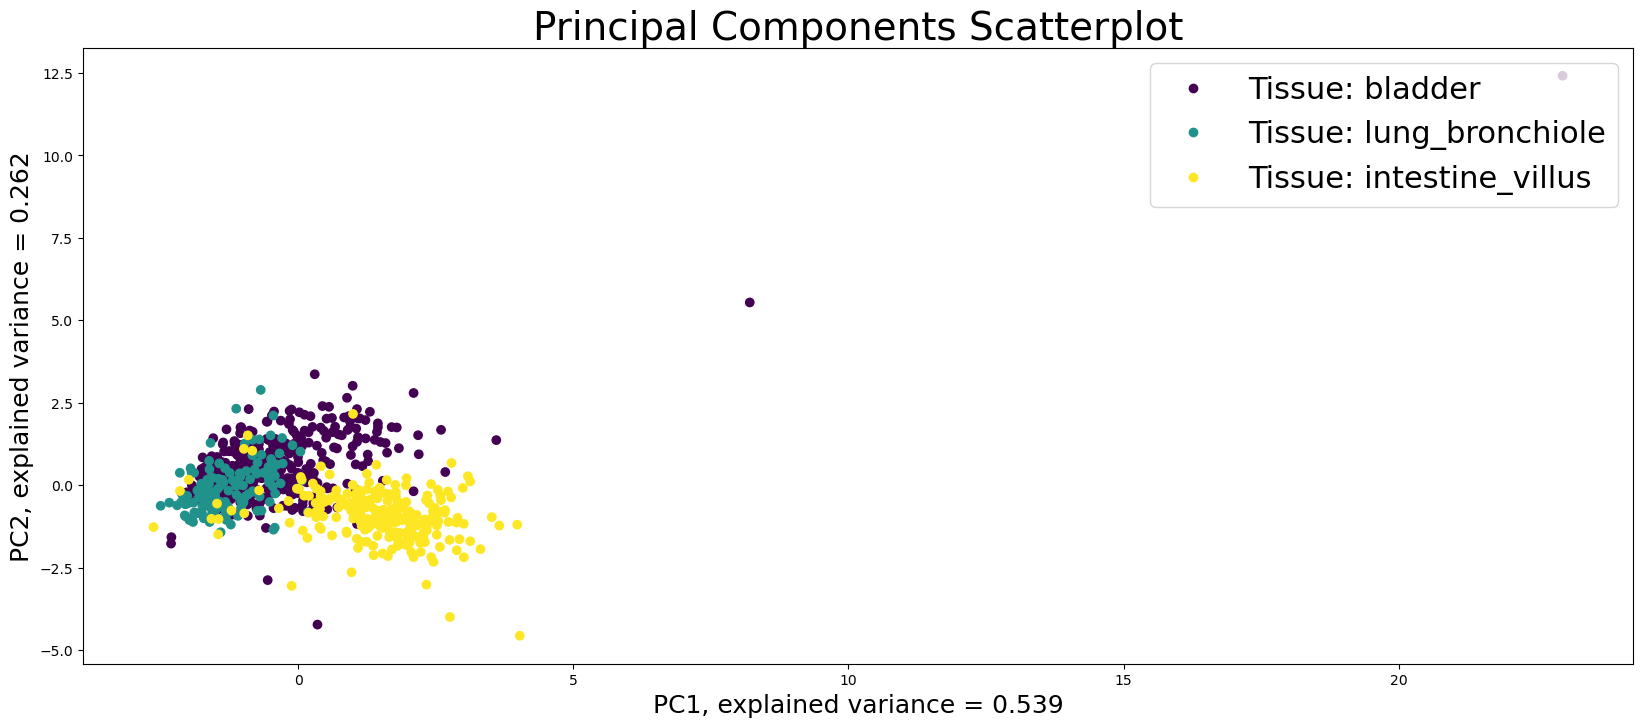

In [28]:
# Scatter plot of the principal components
pc_data = pca_out.transform(scaled_cell_stats_df[numeric_features])
tissue_to_float = {
    'bladder': 0,
    'lung_bronchiole': 0.5,
    'intestine_villus': 1   
}
tissue_ids = [tissue_to_float[tissue] for tissue in scaled_cell_stats_df.tissue]

fig, ax = plt.subplots(figsize=(20, 8))

scatter = ax.scatter(
    x=pc_data[:, 0],
    y=pc_data[:, 1],
    c=tissue_ids,
    cmap='viridis'
)

ax.set_xlabel(f"PC1, explained variance = {round(pca_out.explained_variance_ratio_[0], 3)}", fontsize=18)
ax.set_ylabel(f"PC2, explained variance = {round(pca_out.explained_variance_ratio_[1], 3)}", fontsize=18)

ax.set_title("Principal Components Scatterplot", fontsize=28)

ax.legend(handles=scatter.legend_elements()[0], 
          labels=list([f"Tissue: {name}" for name in tissue_to_float.keys()]),
          loc="upper right",
          fontsize=22
          )

plt.show()

### Plots of the single features

In [38]:
# uom = '\u00B5m' + '\u00B2'
# plot_cell_stats_distrib("cell_surface_area", uom, "../Cell_Meshes/for_cell_statistics/data_analysis/plots/")

# uom = '\u00B5m' + '\u00B3'
# plot_cell_stats_distrib("cell_volume", uom, "../Cell_Meshes/for_cell_statistics/data_analysis/plots/")

# uom = None
# plot_cell_stats_distrib("cell_isoperimetric_ratio", uom, "../Cell_Meshes/for_cell_statistics/data_analysis/plots/")

# uom = None
# plot_cell_stats_distrib("cell_nb_of_neighbors", uom, "../Cell_Meshes/for_cell_statistics/data_analysis/plots/")

# uom = None
# plot_cell_stats_distrib("cell_elongation", uom, "../Cell_Meshes/for_cell_statistics/data_analysis/plots/")

In [142]:
def grid_plot_cell_stats_distrib(df, unit_of_measures=None, save_dir=None, show=False):

    #store non-numerical columns, then drop them from the df
    tissue_ids = df['tissue'].values
    numeric_df = deepcopy(df)
    numeric_df = numeric_df.drop(columns=['cell_ID', 'tissue'])

    # Define 3 colors from the viridis palette
    colors = sns.color_palette('viridis', 3)

    # Create a separate figure for each tissue type in the data
    tissues = np.unique(tissue_ids)

    # Define dictionary that links tissue to cell_type
    tissue_to_type = dict(zip(tissues, ["Transitional", "Simple Cuboidal", "Simple Columnar"]))
    # tissue_to_type = dict(zip(tissues, ["Simple Cuboidal", "Simple Columnar"]))

    # Big figure to accomodate all the plots
    # fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(24, 12))
    # plt.suptitle("Morphological cell statistics comparison", fontsize=24)

    fig = plt.figure(figsize=(24, 12))
    # fig.tight_layout(pad=3.0)
    subplot_id = 1

    for i, tissue in enumerate(tissues):
        for j, column in enumerate(numeric_df.columns):

            # Find the max on the x and y-axes to have the same axes length
            max_x = max(numeric_df[column])
            max_x = max_x + 0.1*max_x

            # Get the unit of measure
            unit_of_measure = unit_of_measures[j]

            # Get the current axis object
            ax = fig.add_subplot(len(tissues), len(numeric_df.columns), subplot_id)
            subplot_id += 1

            # Subset the data for the current tissue
            data = numeric_df[tissue_ids == tissue]

            # Map kernel density plot onto the axes, using shading and color
            sns.kdeplot(data=data, x=column, fill=True, color=colors[i], ax=ax, clip=(0.0, max_x))

            # Map rugplot to the axes, using height to adjust the size of the ticks
            sns.rugplot(data=data, x=column, height=0.125, color=colors[i], ax=ax)

            # Set title and axes labels
            if j == 0:
                ax.set_title(f'{tissue.title()}: {tissue_to_type[tissue]}', fontsize=20)

            if unit_of_measure:
                xlab = column.replace("_", " ").title() + f" ({unit_of_measure})"
            else:
                xlab = column.replace("_", " ").title()
            ax.set_xlabel(xlab, fontsize=20)
            ax.set_ylabel('Density', fontsize=16)

            # Remove y-axis ticks and set x and y-axis limits for the current plot
            ax.set_yticks([])
            ax.set_xlim([0, max_x])
            # ax.set_ylim([0, max_y])

            # Remove the square around the plot
            sns.despine(left=False, bottom=False, top=True, right=True)

            # Remove x-axis from the first 2 plots
            if i < len(tissues)-1:
                ax.set_xticks([])
                ax.set_xlabel("")
                ax.spines['bottom'].set_visible(False)

    fig.suptitle("Morphological cell statistics comparison", fontsize=24)

    # Save the current plot
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_name = f"grid_kdeplot.jpg"
        plt.savefig(os.path.join(save_dir, save_name), bbox_inches='tight', dpi=150) 

    # Show the plot
    if show:
        plt.show()
    else:
        plt.close()


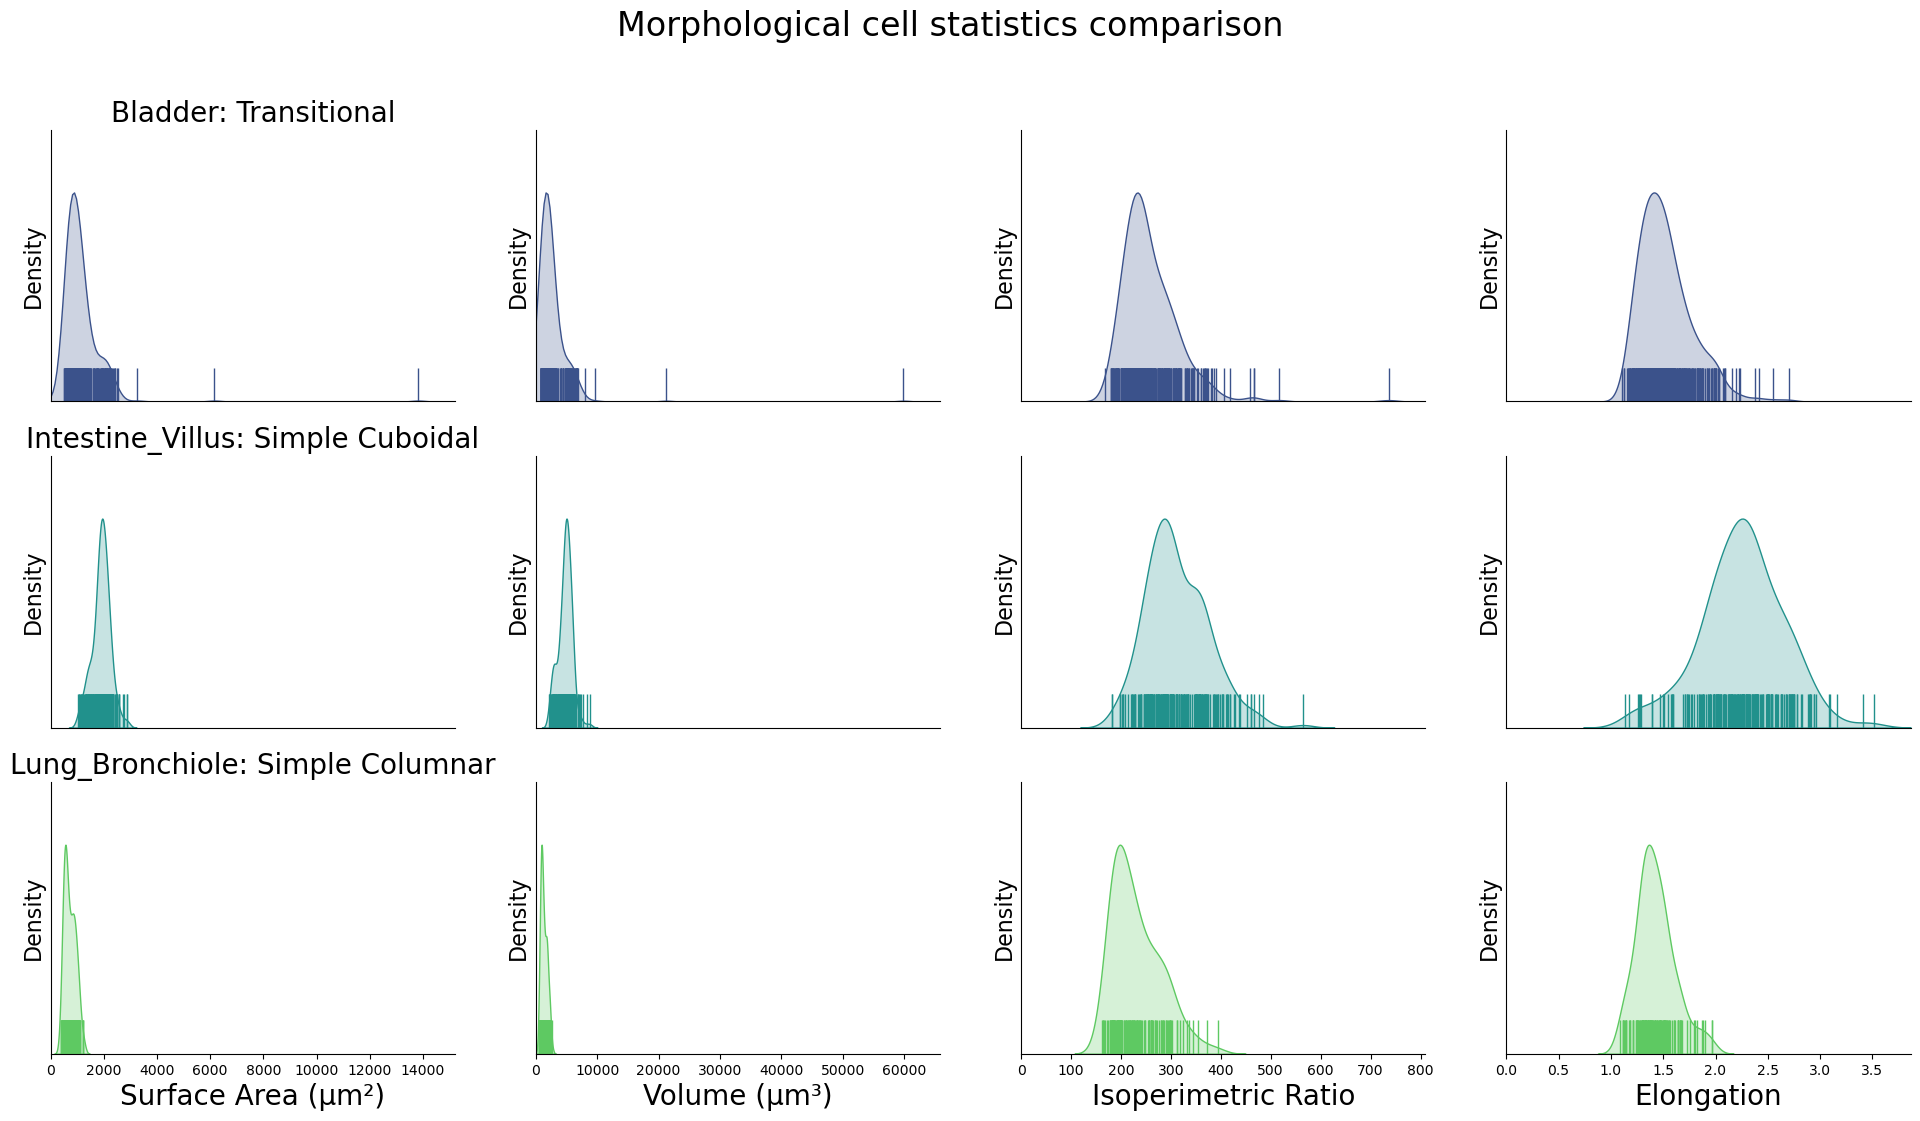

In [143]:
ordered_columns = ['cell_ID', 'tissue', 'surface_area', 'volume', 'isoperimetric_ratio', 'elongation']
grid_plot_df = numerical_cell_stats_df[ordered_columns].copy()

grid_plot_cell_stats_distrib(grid_plot_df, 
                             ['\u00B5m' + '\u00B2', '\u00B5m' + '\u00B3', None, None], 
                             save_dir="../images",
                             show=True)

In [144]:
# Discrete plot of number of neighbors
def barplot_num_neighbors(df, save_dir=None, show=True):
    
    column = "num_neighbors"

    # Define 3 colors from the viridis palette
    colors = sns.color_palette('viridis', 3)

    # Create a separate figure for each tissue type in the data
    tissues = df['tissue'].unique()

    # Define dictionary that links tissue to cell_type
    tissue_to_type = dict(zip(tissues, ["Transitional", "Simple Cuboidal", "Simple Columnar"]))
    # tissue_to_type = dict(zip(tissues, ["Simple Cuboidal", "Simple Columnar"]))

    # Find the max on the x and y-axes to have the same axes length
    # max_x = max(df[column])
    # max_x = max_x + 0.1*max_x
    # max_x = 25

    fig = plt.figure(figsize=(20, 5))
    subplot_id = 1
    for i, tissue in enumerate(tissues):
        # Get the current axis object
        ax = fig.add_subplot(1, len(tissues), subplot_id)
        subplot_id += 1

        # Subset the data for the current tissue
        data = df[df['tissue'] == tissue][column]

        # Count the frequency of each unique value
        unique_values, counts = np.unique(data, return_counts=True)

        # Create a bar plot using Seaborn
        sns.barplot(x=unique_values, y=counts, color=colors[i])

        # Set title and axes labels
        ax.set_title(f'{tissue.title()}: {tissue_to_type[tissue]}', fontsize=20)

        xlab = column.replace("_", " ").title()
        ax.set_xlabel(xlab, fontsize=20)
        ax.set_ylabel('Counts', fontsize=16)

        # Remove y-axis ticks and set x and y-axis limits for the current plot
        # ax.set_yticks([])
        # ax.set_xlim([0, max_x])
        # ax.set_ylim([0, max_y])

        # Remove the square around the plot
        sns.despine(left=False, bottom=False, top=True, right=True)

    # fig.suptitle("Nb of neighbors comparison", fontsize=24)

    # Save the current plot
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_name = f"num_neighbors_barplot.jpg"
        plt.savefig(os.path.join(save_dir, save_name), bbox_inches='tight', dpi=150) 

    # Show the plot
    if show:
        plt.show()
    else:
        plt.close()
    

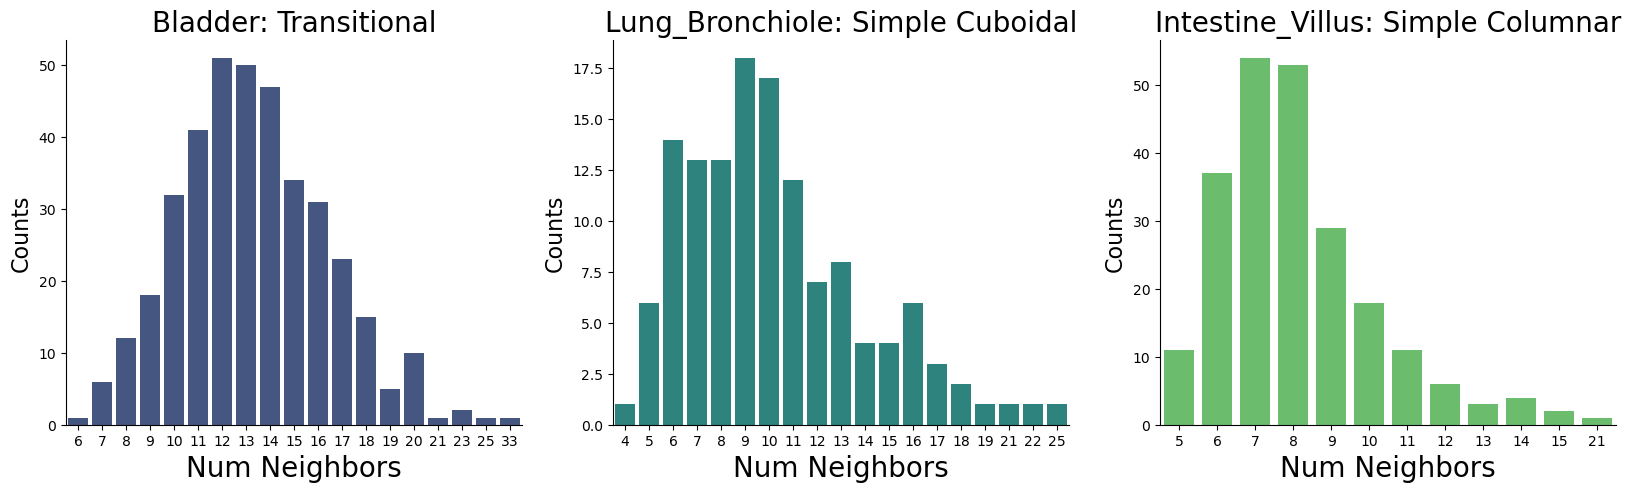

In [145]:
barplot_num_neighbors(numerical_cell_stats_df, save_dir="../master_thesis_docs/IMGS/for_group_meeting/", show=True)

## Lewis' Law plots

Lewis' law states that the average apical area of cells having $n$ neighbors $\bar{A}_n$ is linearly related to the number of neighbors $n$ itself. $\newline$
In particular we have the following relation:
$$ \frac{\bar{A}_n}{\bar{A}} = \frac{n - 2}{4} $$
In 3D we could have a similar relation for volumes, namely:
$$ \frac{\bar{V}_n}{\bar{V}} \sim n $$


In [151]:
def lewis_law_plots(
        df, 
        save_dir,
        show=True,
        feature='volume',
        fit_degrees=[1,2]
) -> None:
    
    # Create a separate figure for each tissue type in the data
    tissues = df['tissue'].unique()

    # Define 3 colors from the viridis palette
    colors = sns.color_palette('viridis', len(tissues))

    # Define dictionary that links tissue to cell_type
    tissue_to_type = dict(zip(tissues, ["Transitional", "Simple Cuboidal", "Simple Columnar"]))
    # tissue_to_type = dict(zip(tissues, ["Simple Cuboidal", "Simple Columnar"]))

    fig = plt.figure(figsize=(18, 6))
    fig.suptitle(f"Lewis' Law for {feature.replace('_', ' ')}", fontsize=30)
    subplot_id = 1
    for i, tissue in enumerate(tissues):
        # Get the current axis object
        ax = fig.add_subplot(1, len(tissues), subplot_id)
        subplot_id += 1

        # Subset the data for the current tissue
        tissue_df = df[df['tissue'] == tissue]

        # Compute global volume average
        global_avg = tissue_df[feature].mean()

        # Compute average volume for each value of n
        num_neighbors_values = np.asarray(tissue_df['num_neighbors'].unique())
        local_avgs, local_sds = {}, {}
        for n in num_neighbors_values:
            #subset the df
            data = tissue_df[tissue_df['num_neighbors'] == n][feature]
            # compute the average for this n
            local_avgs[n] = data.mean()/global_avg
            local_sds[n] = (data/global_avg).std()/np.sqrt(len(data))
        # Sort dict by key
        local_avgs = dict(sorted(local_avgs.items()))
        local_sds = dict(sorted(local_sds.items()))
        std_devs = list(local_sds.values())

        # Compute fitted lines
        x = np.asarray(list(local_avgs.keys()), dtype=np.int64)
        y = list(local_avgs.values())
        coeff_sets = [np.polyfit(x, y, degree) for degree in fit_degrees]
        polylines = [np.poly1d(coeff_set) for coeff_set in coeff_sets] 
        x_fit = np.linspace(min(x), max(x), max(x)-min(x)+1, dtype=np.int32) 
        y_linear, y_quadratic = (polyline(x_fit) for polyline in polylines)

        # Plot the values and the fitted lines
        # scatter = ax.scatter(x, y, c=colors[i])
        ax.errorbar(x, y, yerr=std_devs, fmt='o', color=colors[i], ecolor='grey', capsize=4)
        linear, = ax.plot(x_fit, y_linear, color='red', linestyle='--', label='Linear fit')   
        quadratic, = ax.plot(x_fit, y_quadratic, color='green', linestyle='-.', label='Quadratic fit')

        # Set title and axes labels
        ax.set_title(f'{tissue.title()}: {tissue_to_type[tissue]}', fontsize=20)
        ax.set_xlabel(r'Number of neighbors $(n)$', fontsize=20)
        if feature == 'volume':
            ax.set_ylabel(r'$\bar{V}_n / \bar{V}$', fontsize=20)
        elif feature == 'surface_area':
            ax.set_ylabel(r'$\bar{A}_n / \bar{A}$', fontsize=20)
        ax.set_xticks(x_fit)
        ax.legend(handles=[linear, quadratic], loc='lower right')

        # Remove the square around the plot
        sns.despine(left=False, bottom=False, top=True, right=True)
    
    plt.subplots_adjust(top=0.8)

    # Save the current plot
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_name = f"lewis_law_{feature}_plots.jpg"
        plt.savefig(os.path.join(save_dir, save_name), bbox_inches='tight', dpi=150) 

    # Show the plot
    if show:
        plt.show()
    else:
        plt.close()


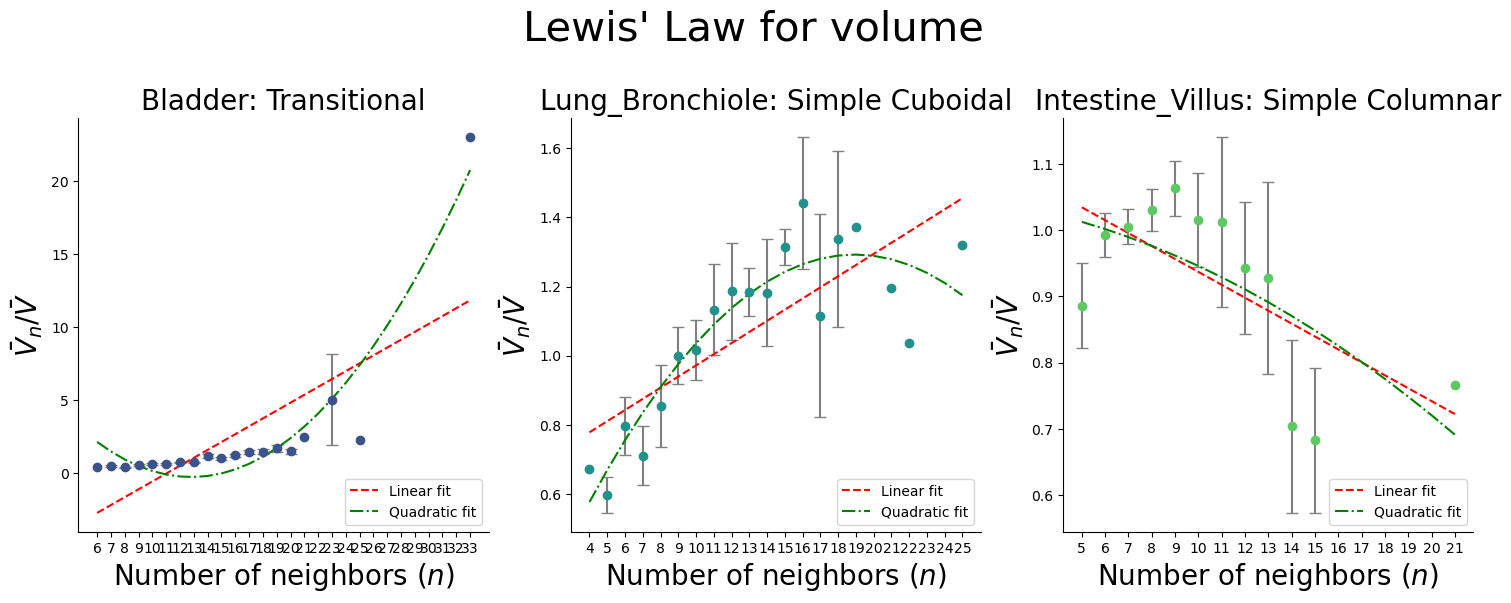

In [152]:
lewis_law_plots(
    numerical_cell_stats_df,
    './images',
    feature='volume'
)

## Plot of number of neighbors vs normalized volume

In [153]:
def volume_neighbors_scatter_plot(
    df,     
    save_dir,
    show=True,
) -> None:
    
    # Create a separate figure for each tissue type in the data
    tissues = df['tissue'].unique()

    tissue_to_float = dict(zip(tissues, np.linspace(0, 1, len(tissues))))
    tissue_ids = [tissue_to_float[tissue] for tissue in df['tissue']]

    # Define dictionary that links tissue to cell_type
    tissue_to_type = dict(zip(tissues, ["Transitional", "Simple Cuboidal", "Simple Columnar"]))
    # tissue_to_type = dict(zip(tissues, ["Simple Cuboidal", "Simple Columnar"]))

    normalized_volume = df['volume'].values / df['volume'].mean()

    fig, ax = plt.subplots(figsize=(20, 8))

    scatter = ax.scatter(
        x=df['num_neighbors'],
        y=normalized_volume,
        c=tissue_ids,
        cmap='viridis'
    )

    ax.set_xlabel(r'Number of neighbors $(n)$', fontsize=20)
    ax.set_ylabel(r'$V / \bar{V}$', fontsize=20)
    ax.set_title("Volume vs. Number of Neighbors Scatterplot", fontsize=28)
    # ax.legend(handles=scatter.legend_elements()[0], 
    #     labels=list([f"{name.title()}: {tissue_to_type[name]}" for name in tissues]),
    #     loc="upper right",
    #     fontsize=22
    # )
    
    # Save the current plot
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_name = f"volume_vs_neighbors_plot.jpg"
        plt.savefig(os.path.join(save_dir, save_name), bbox_inches='tight', dpi=150) 

    # Show the plot
    if show:
        plt.show()
    else:
        plt.close()

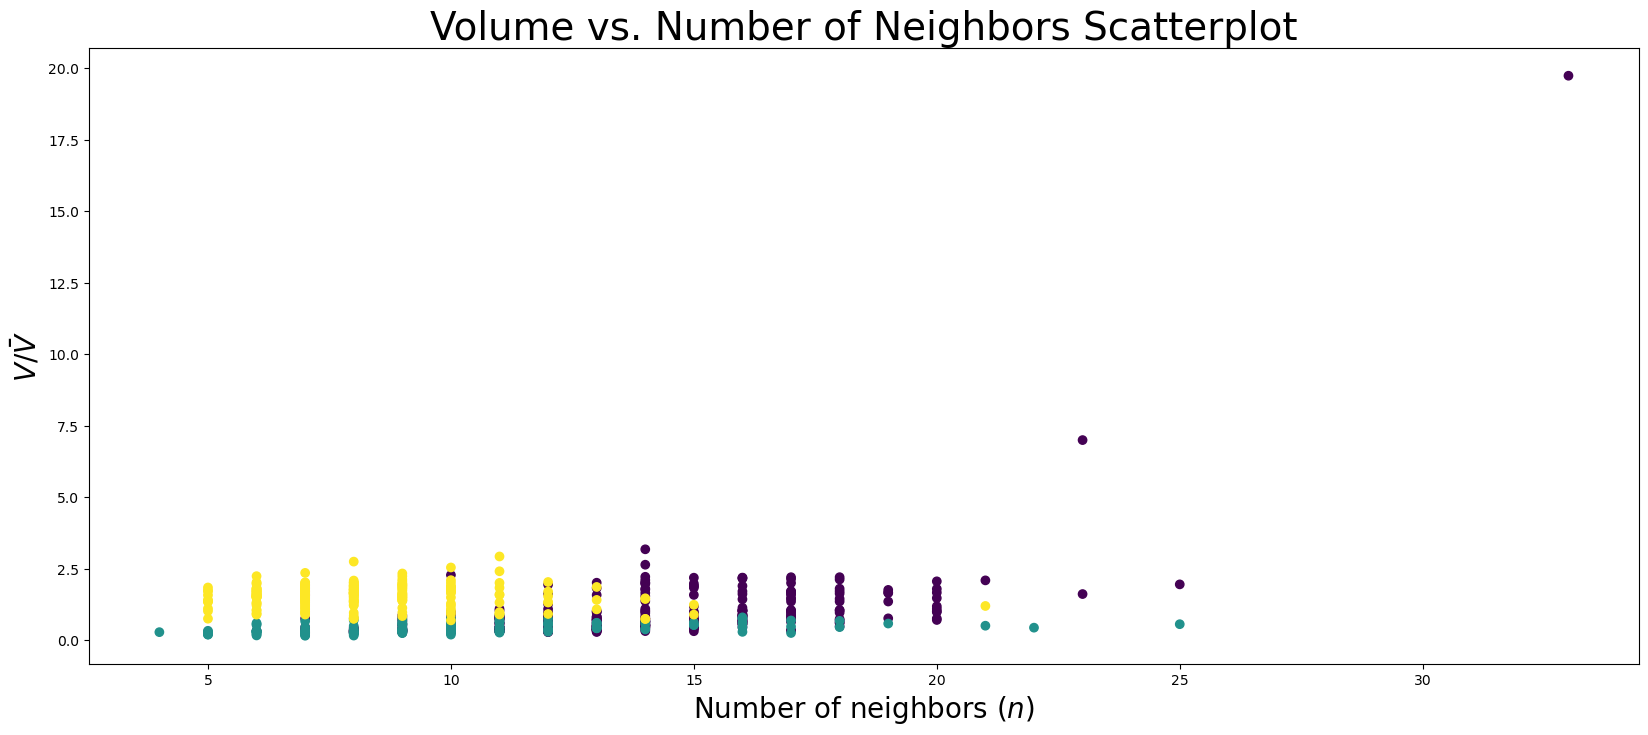

In [154]:
volume_neighbors_scatter_plot(
    numerical_cell_stats_df,
    './images/'
)

In [155]:
def volume_neighbors_heatmaps(
    df,     
    save_dir,
    show=True,
) -> None:
    
    # Create a separate figure for each tissue type in the data
    tissues = df['tissue'].unique()

    tissue_to_float = dict(zip(tissues, np.linspace(0, 1, len(tissues))))
    tissue_ids = [tissue_to_float[tissue] for tissue in df['tissue']]

    # Define dictionary that links tissue to cell_type
    tissue_to_type = dict(zip(tissues, ["Transitional", "Simple Cuboidal", "Simple Columnar"]))
    # tissue_to_type = dict(zip(tissues, ["Simple Cuboidal", "Simple Columnar"]))

    fig = plt.figure(figsize=(18, 6))
    fig.suptitle(f"Volume vs. Number of Neighbors Heatmaps", fontsize=30)
    subplot_id = 1
    for i, tissue in enumerate(tissues):
        # Get the current axis object
        ax = fig.add_subplot(1, len(tissues), subplot_id)
        subplot_id += 1

        # Subset the data for the current tissue
        tissue_df = df[df['tissue'] == tissue]

        # Compute global volume average
        global_avg = tissue_df['volume'].mean()

        # Compute average volume for each value of n
        num_neighbors_values = np.asarray(tissue_df['num_neighbors'].unique())
        volume_dict = {}
        for n in num_neighbors_values:
            normalized_volume = tissue_df[tissue_df['num_neighbors'] == n]['volume']/global_avg
            volume_dict[n] = normalized_volume.values
        # Sort dict by key
        volume_dict = dict(sorted(volume_dict.items()))
        sorted_num_neighbors = list(volume_dict.keys())

        # Create matrix for heatmap
        volume_matrix = []
        for _, volumes in volume_dict.items():
            volume_matrix.append(sorted(volumes))

        # Pad the matrix to same length (put 0 in front of each list)
        max_len = max([len(v) for v in volume_matrix])
        for i, volumes in enumerate(volume_matrix):
            if len(volumes) < max_len:
                volume_matrix[i] = np.concatenate((np.asarray([0]*(max_len-len(volumes))), volumes))
        volume_matrix = np.asarray(volume_matrix)

        # Plot the heatmap
        ax = sns.heatmap(
            volume_matrix.T, 
            cmap='viridis',
            cbar_kws={"shrink": .5}
        )

        ax.set_xlabel(r'Number of neighbors $(n)$', fontsize=18)
        ax.set_xticklabels(sorted_num_neighbors)
        ax.set_yticklabels('')
        ax.yaxis.set_ticks([])
        ax.set_title(f'{tissue.title()}: {tissue_to_type[tissue]}', fontsize=18)

    plt.subplots_adjust(top=0.85)

    # Save the current plot
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_name = f"volume_neighbors_heatmap.jpg"
        plt.savefig(os.path.join(save_dir, save_name), bbox_inches='tight', dpi=150) 

    # Show the plot
    if show:
        plt.show()
    else:
        plt.close()

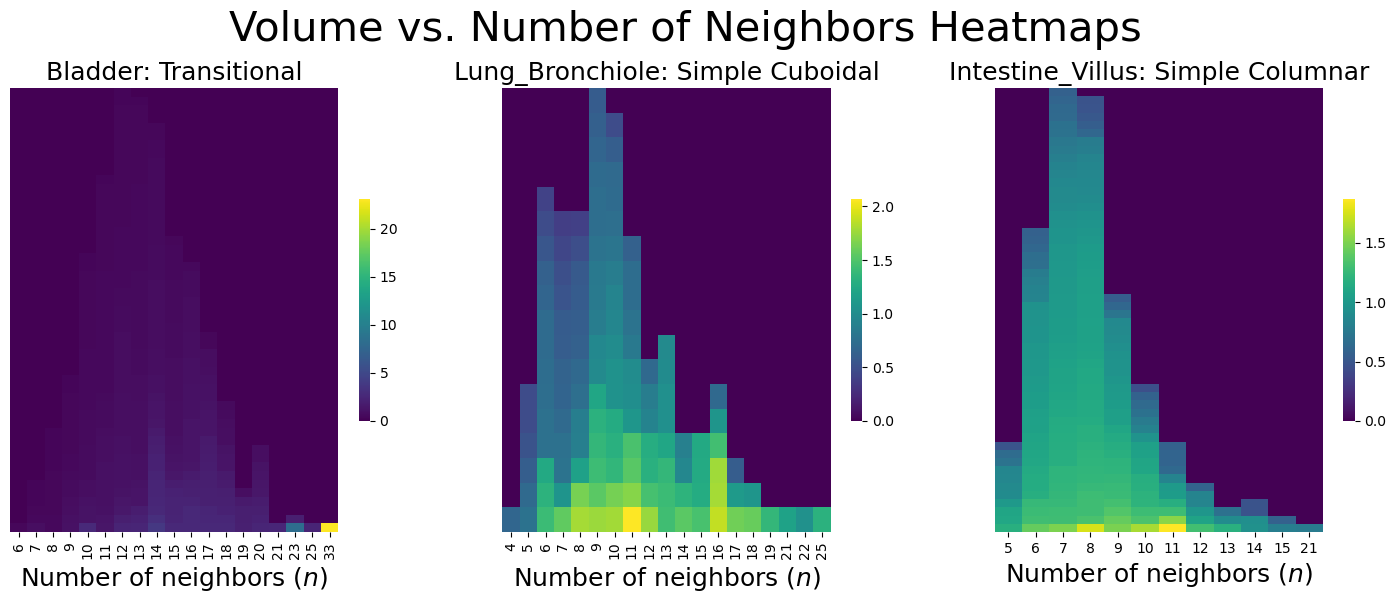

In [156]:
volume_neighbors_heatmaps(numerical_cell_stats_df, './images/')

## ANOVA/MANOVA tests between the 3 groups

In [55]:
def one_way_anova(df, column):
    bladder_vals = df.loc[df["tissue_id"].values == "bladder", column]
    lung_vals = df.loc[df["tissue_id"].values == "lung", column]
    intestine_vals = df.loc[df["tissue_id"].values == "intestine", column]
    print(f"Bladder: mean={bladder_vals.mean()}, Std={bladder_vals.std()}")
    print(f"Lung: mean={lung_vals.mean()}, Std={lung_vals.std()}")
    print(f"Intestine: mean={intestine_vals.mean()}, Std={intestine_vals.std()}")
    f_val, p_val = stats.f_oneway(bladder_vals, lung_vals, intestine_vals)
    return f_val, p_val 

In [57]:
fv, pv = one_way_anova(cell_stats_df, "cell_surface_area")
print(f"Surface Area -> F-value: {fv}, p-value: {pv}")
print("-------------------------------------------------------------")

fv, pv = one_way_anova(cell_stats_df, "cell_volume")
print(f"Volume -> F-value: {fv}, p-value: {pv}")
print("-------------------------------------------------------------")

fv, pv = one_way_anova(cell_stats_df, "cell_isoperimetric_ratio")
print(f"Isoperimetric Ratio -> F-value: {fv}, p-value: {pv}")
print("-------------------------------------------------------------")

fv, pv = one_way_anova(cell_stats_df, "cell_elongation")
print(f"Elongation -> F-value: {fv}, p-value: {pv}")
print("-------------------------------------------------------------")

fv, pv = one_way_anova(cell_stats_df, "cell_nb_of_neighbors")
print(f"# neighbors -> F-value: {fv}, p-value: {pv}")
print("-------------------------------------------------------------")

Bladder: mean=964.1785048526102, Std=441.84045468125237
Lung: mean=677.5749217332999, Std=223.26074379918944
Intestine: mean=1823.4190614766705, Std=391.72226972854105
Surface Area -> F-value: 463.3269361198989, p-value: 4.288053629351522e-136
-------------------------------------------------------------
Bladder: mean=2325.902189394351, Std=1651.3912680224496
Lung: mean=1263.6315009202694, Std=556.5162191097531
Intestine: mean=4749.539546966777, Std=1293.5244668207265
Volume -> F-value: 311.690033369257, p-value: 7.728194324496476e-102
-------------------------------------------------------------
Bladder: mean=185.04881214112564, Std=31.29927620354817
Lung: mean=206.5168781478817, Std=37.56705516812941
Intestine: mean=276.9957925421087, Std=52.587551687515734
Isoperimetric Ratio -> F-value: 427.30399922446804, p-value: 1.5975945247429276e-128
-------------------------------------------------------------
Bladder: mean=1.3891286966636642, Std=0.20067708726000083
Lung: mean=1.431062472919

## Inspect cells with abnormal number of neighbors

In [44]:
viewer = napari.Viewer()
# Open the image in napari and investigate
path_to_img_dir = 'output_lung_new_sample_b_curated_segmentation_central_crop_relabel_seq_s_10_e_6_d_8'
img = imread(os.path.join(path_to_img_dir, 'processed_labels.tif'))
viewer.add_labels(img, name='lung_labels')

<Labels layer 'lung_labels' at 0x7fe76a5209a0>

In [5]:
# Intestine
filtered_df = bladder_df[bladder_df['num_neighbors'] == 0]
cell_ids = filtered_df['cell_ID'].values
print(cell_ids)

for cell_id in cell_ids[:10]:
    single_cell = img.copy()
    single_cell[single_cell != cell_id] = 0
    viewer.add_labels(single_cell, name=f'cell_{cell_id}')

[  2   3   4   6   7   8   9  10  11  12  13  14  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  51  53  54  55  56  57  59  60  61  69
  72  75  76  83  86  90  91  93 102 107 115 117 118 120 122 124 127 138
 140 143 144 150 151 152 154 161 167 168 169 177 185 191 193 195 201 204
 218 223 225 229 230 233 234 239 241 242 244 245 247 248 249 252 254 259
 262 270 271 283 288 294 310 311 317 318 324 329 335 336 338 339 340 345
 353 362 364 365 366 367 377 378 380 381 382 385 386 387 389 390 396 397
 402 406 407 410 411 412 413 415 417 419 420 424 426 432 433 434 435 437
 440 443 448 449 452 456 458 459 460 462 463 465 467 469 471 472 473 474
 475 476 477 478 479 480 481 485 486 487 488 490 491 492 495 496 497 498
 499 516 527 559 561 563 581 589 592 593 594 597 598 599 600 604 605 606
 613 614 615 616 617 618 621 622 623 624 625 627 629 630 631 632 633 634
 635 636 638]


In [45]:
cell_ids = lung_df[lung_df['exclude_cell'] == True]['cell_ID'].values

for cell_id in cell_ids:
    single_cell = img.copy()
    single_cell[single_cell != cell_id] = 0
    viewer.add_labels(single_cell, name=f'cell_{cell_id}')